In [2]:
import torch
from torch import optim
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import numpy as np
from torchviz import make_dot
from torch.utils.data import DataLoader
from pathlib import Path
import pandas as pd

from autoencoder import AutoEncoder
import pickle

# https://stackoverflow.com/questions/8223811/a-top-like-utility-for-monitoring-cuda-activity-on-a-gpu

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
data_path = "/home/amal/UbuntuDocuments/data/torch_datasets"

train_data = datasets.CelebA(data_path, split="train", transform=transforms.PILToTensor(), download=True)
validation_data =  datasets.CelebA(data_path, split="valid", transform=transforms.PILToTensor(), download=True)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
def validate(
    model: torch.nn.Module,
    val_dataloader: DataLoader,
    device,
):
    val_loss = []
    model.eval()
    with torch.no_grad():
        for indx, batch in enumerate(val_dataloader):
            input_image = batch[0]
            input = torch.tensor(input_image/255, dtype=torch.float).to(device)
            output = model(input)

            loss = loss_func(output, input)
            val_loss.append(loss.item())
    return np.mean(val_loss)


def train_epoch(
    model: torch.nn.Module,
    optimizer: torch.optim,
    train_loader: DataLoader,
    loss_fn,
    device,
):
    # specifcy training mode
    model.train()
    batch_loss = []
    for indx, batch in enumerate(train_loader):
    
        if indx % 25 == 0:
            print(f"running index: {indx}")
        
        input_image = batch[0]
        input = torch.tensor(input_image/255, dtype=torch.float).to(device)
        output = model(input)
    
        loss = loss_func(output, input)
        batch_loss.append(loss.item())
        loss.backward()
        opt.step()
        opt.zero_grad()

    return batch_loss


In [6]:
batch_size = 256
latent_dim = 200
train_dataloader = DataLoader(train_data, batch_size=batch_size)
val_dataloader = DataLoader(validation_data, batch_size=batch_size)
loss_func = nn.MSELoss(reduction = "mean")

N_epochs = 15
out_path = Path("/home/amal/UbuntuDocuments/projects/generative_modelling/saved_models")

load_model = False

In [7]:
model = AutoEncoder(latent_dim=latent_dim).to(device)
opt = optim.Adam(model.parameters())
if load_model:
    checkpoint_path = out_path / f"autoencoder_epoch_14.pth"
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint["model_state_dict"])
    opt.load_state_dict(checkpoint['optimizer_state_dict'])


In [8]:
if Path("losses.pkl").is_file():
    with open("losses.pkl", "rb") as f:
        losses = pickle.load(f)
else:
    losses = []


batch_loss = []


start_epoch = len(losses)

TRAIN_MODEL = False

if TRAIN_MODEL:
    for epoch in range(N_epochs):

        epoch = start_epoch+epoch
        
        print(f"---\nRunning epoch {epoch + 1}")
        
        b_losses = train_epoch(
            model,
            opt,
            train_dataloader,
            loss_func,
            device
        )
        epoch_loss = np.mean(b_losses)
        val_loss = validate(
            model,
            val_dataloader,
            device,
        )
    
        out = {
            "epoch_loss" : epoch_loss,
            "val_loss" : val_loss
        }
        losses.append(out)
        batch_loss = batch_loss + b_losses
        out_file = out_path / f"autoencoder_epoch_{epoch}.pth"
        torch.save(
            {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': epoch_loss,
            'val_loss' : val_loss    
            },
            out_file
        )

    with open("losses.pkl", "wb") as f:
        pickle.dump(losses, f)




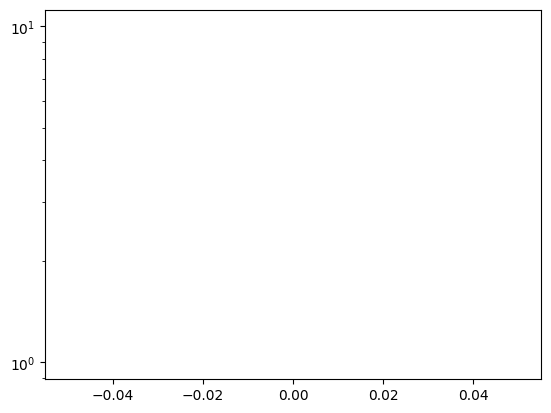

In [9]:
plt.plot(batch_loss,)
plt.yscale("log")

In [13]:
loss_df = pd.DataFrame(losses)

In [14]:
loss_df

,epoch_loss,val_loss
0,0.084309,0.048633
1,0.031551,0.023009
2,0.015994,0.011580
3,0.011255,0.011027
4,0.009849,0.007407
5,0.007303,0.007122
6,0.007092,0.006959
7,0.006952,0.006848
8,0.006828,0.006736
9,0.006698,0.006611


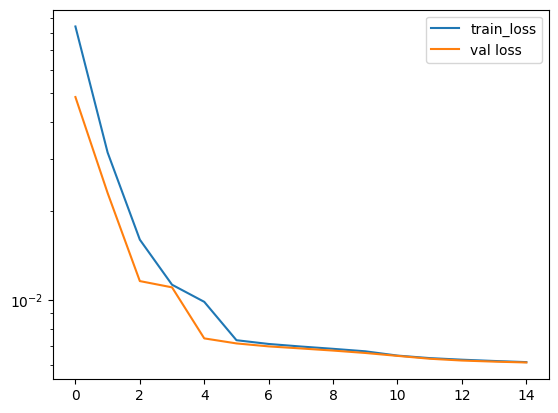

In [15]:
plt.plot(loss_df.epoch_loss, label = "train_loss")
plt.plot(loss_df.val_loss, label = "val loss")
plt.yscale("log")
plt.legend()

## Load checkpoint and evalute model

In [16]:
model = AutoEncoder(latent_dim=latent_dim)
model.to(device)
checkpoint_path = out_path / f"autoencoder_epoch_14.pth"
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.01)
    )
    (4): Sequ

In [32]:
val_index = 5

test = torch.tensor(validation_data[val_index][0]/255, dtype=torch.float).to(device)

/tmp/ipykernel_4036/1538022774.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test = torch.tensor(validation_data[val_index][0]/255, dtype=torch.float).to(device)


In [33]:
test_out = model(test.unsqueeze(0))

In [34]:
test_out.shape

torch.Size([1, 3, 218, 178])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


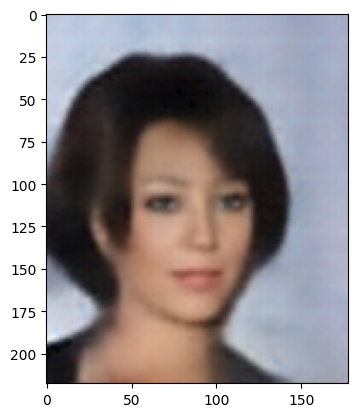

In [35]:
plt.imshow(test_out.detach().cpu().squeeze().permute(1, 2, 0))

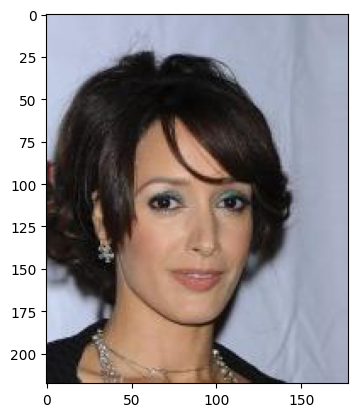

In [36]:
plt.imshow(validation_data[val_index][0].permute(1, 2, 0))

In [18]:
model.recursive_apply(
            (218, 178), model.conv_output_shape, 5
        )

(7, 6)

In [19]:
7*6*128

5376

In [20]:
14*12*128, 7*6*256

(21504, 10752)